In [75]:
from reweight_functions import *
import pickle

In [76]:
import mdtraj as md
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
import seaborn as sns
import pyblock

In [77]:
main_path = '/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/'

outdir = os.path.join(main_path, 'reweight_trial/')
datadir = main_path
expdatadir = main_path
weights_dir = os.path.join(outdir, 'weights/')
traj_dir = os.path.join(main_path, 'trajectory/')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)

rep0 = traj_dir + 'Tau5R2R3_CYE.xtc'
pdb = traj_dir + 'Tau5R2R3_CYE.pdb'
helixpdb = traj_dir + 'R2R3_all_helix.pdb'
trj = md.load(rep0, top=pdb)

In [78]:
chemical_shifts = ['CB', 'HA', 'CA', 'H', 'N']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

# reweighting_keys = ['CA', 'H', 'N', 'C']
reweighting_keys = ['CA']
theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1.}

to_remove = ['HA','HA2', 'HA3', 'CB']

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))

Main settings:

Reweighting keys: ['CA']


In [79]:
expdata = read_exp_cs(join(expdatadir, 'CYE_CS_exp.dat'))
compdata = read_cs_md(join(datadir, 'cs_assignment.csv'), )

In [80]:
def adjust_and_clean_keys(nested_dict, add_value=389, keys_to_remove=['390', '447']):
    new_dict = {}
    for shift_type, shifts in nested_dict.items():
        adjusted_shifts = {str(int(k) + add_value): v for k, v in shifts.items()}
        # Remove specified keys
        for key in keys_to_remove:
            if key in adjusted_shifts:
                del adjusted_shifts[key]
        new_dict[shift_type] = adjusted_shifts
    return new_dict

def Align_Comp_Exp_Data(compdata, expdata):
    # Adjust and clean keys in compdata only
    compdata = adjust_and_clean_keys(compdata)

    for data1, data1_t in zip([compdata, expdata], ['comp', 'exp']):
        data2 = expdata if data1_t == 'comp' else compdata
        to_align = {}
        for key1 in data1.keys():
            to_align[key1] = []
            for key2 in data1[key1].keys():
                if key2 not in data2[key1].keys() or data1[key1][key2][0] == 0.0:
                    to_align[key1].append(key2)

        for key1 in to_align.keys():
            for key2 in to_align[key1]:
                if key2 in data1[key1].keys():
                    data1[key1].pop(key2)
                if key2 in data2[key1].keys():
                    data2[key1].pop(key2)
                  
    return compdata, expdata

In [81]:
# def make_new_dict(nested_dict, add_value=389, keys_to_remove=['390', '447']):
#     new_dict = {}
#     for shift_type, shifts in nested_dict.items():
#         adjusted_shifts = {str(int(k) + add_value): v for k, v in shifts.items()}
#         # Remove specified keys
#         for key in keys_to_remove:
#             if key in adjusted_shifts:
#                 del adjusted_shifts[key]
#         new_dict[shift_type] = adjusted_shifts
#     return new_dict

In [82]:
# new_compdata = make_new_dict(compdata)

In [83]:
# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)


####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])
# nframes = len(compdata['Rg'][0])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N']
Number of frames = 59746


In [84]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['C', 'H', 'N']
C
H
N
CA


In [85]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 5, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA


In [86]:
kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)

In [87]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


Reweight Data = CA
0.83
CA Theta: 0.8299798994974874 Kish: 10.157391 RMSD initail: 0.5377 RMSD final: 0.1701
Initial RMSE reweight data 
 * Total :      0.538
 *    CA :      0.538
Initial RMSE validation data
 * Total :      0.603
 *     C :      0.524
 *     H :      0.200
 *     N :      0.880
Final RMSE reweight data
 * Total :      0.170
 *    CA :      0.170
Final RMSE validation data
 * Total :      0.472
 *     C :      0.386
 *     H :      0.185
 *     N :      0.694
CA
RMSD_initial: 0.538 RMSD_final: 0.170


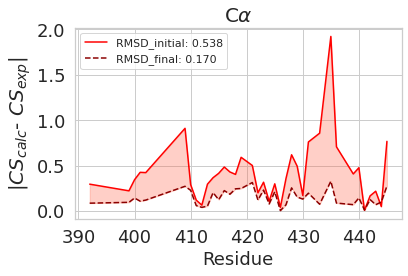

In [88]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()

plot_fitting_data(final_weights)

CA
RMSD_initial: 0.538 RMSD_final: 0.170


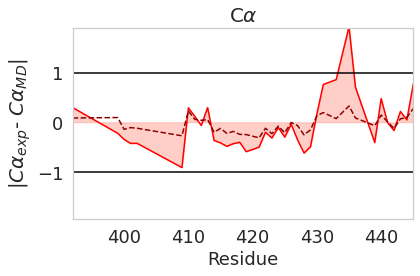

In [89]:
def plot_CA_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()
            if t == 'CA':
                plt.plot(np.asarray(resid), (initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), (reweight - exp), color='darkred',
                         label="RMSD_final:%6.3lf" % rmsd_f, linestyle='dashed')
                plt.fill_between(np.asarray(resid), (initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$C\alpha_{exp}$- $C\alpha_{MD}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.axhline(y=1, color='black', linestyle='-')
                plt.axhline(y=-1, color='black', linestyle='-')
                # plt.xticks(fontsize=16)
                # plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.yticks([-1, 0, 1])    
                plt.grid()
                plt.ylim(-1.95,1.9)
                plt.xlim(392, 445)
                plt.xlabel('Residue', size=18)
                # plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.weird.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

plot_CA_data(final_weights)

In [90]:
# To_Scan=combined_reweighting_keys


# CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
# obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


# s = '{:.2f}'.format(theta_m)

# sigma_reg=theta_m*err_r
# sigma_md=sigma_md_r
        

# nobs_r = len(obs_exp_r)
# nobs_v = len(obs_exp_v)
# weight_bias=np.ones(nframes)
# if 'RDC' in Reweight_Data:    
#        initial_weights=weight_bias
#        initial_weights/=np.sum(initial_weights)
#        initial_obs_r=np.dot(traj_r,initial_weights)
#        initial_obs_r
#        exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
#        calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
#        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
#        #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
#        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
#        #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

#        if(qf_neg<qf_pos):
#         c=-c_neg
#        else: 
#         c=c_pos
    
#        RDC_rows=np.where(data_r_type['RDC']==1)
#        traj_r[RDC_rows]=traj_r[RDC_rows]*c


# res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
# initial_weights = Normalize_Weights(weight_bias)
# initial_obs_r=np.dot(traj_r,initial_weights)
# final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
# final_obs_r=np.dot(traj_r,final_weights)
# Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
# Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
# Kish_ratio = (Ks_a/Ks_b)*100
# RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
# RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

# plot_fitting_data(final_weights)
# print_comb_results()

# np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# # print final weights to file

# f = open("%s/weights_final.a.dat" % CS_dir, "w")
# for w in final_weights:
#        f.write("%e\n" % w)
# f.close()

In [91]:
# combined_reweighting_keys = [reweighting_keys]
# print('Reweighting keys: {}'.format(combined_reweighting_keys))

# To_Scan = combined_reweighting_keys
# thetas = np.linspace(0.01, 5, 20)
# ref_theta = thetas[-1]
# RMSE_dict_combined = {}
# KishScan_combined = {}
# for CS in To_Scan:
#     CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
#     KishScan_combined[CS] = {}
#     CS_dir = join(combined_dir, CS)
#     if not os.path.exists(CS_dir):
#         os.makedirs(CS_dir)
#     print('Reweight Data = {}'.format(CS))
#     RMSE_dict_combined[CS] = {}
#     combined_key_string = CS

#     ### debugging variables
#     compare = []
#     compare_dict_r = {key: {} for key in compdata.keys()}

#     ####### B) The reweighting procedure

#     obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
#         Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
#     # THETA CYCLE
#     theta_list = []
#     kish_list = []
#     rmsd_f_list = []
#     for theta_m in np.flip(thetas):

#         s = '{:.2f}'.format(theta_m)
#         print(s)
#         sigma_reg = theta_m * err_r
#         sigma_md = sigma_md_r
#         RMSE_dict_combined[CS][s] = {}

#         # iv) Print dimensions
#         nobs_r = len(obs_exp_r)
#         nobs_v = len(obs_exp_v)
#         # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

#         # v) perform minimization
#         # OBS: res.X = lagrange multiplier
#         weight_bias = np.ones(nframes)
#         if 'RDC' in Reweight_Data:
#             initial_weights = weight_bias
#             initial_weights /= np.sum(initial_weights)
#             initial_obs_r = np.dot(traj_r, initial_weights)
#             initial_obs_r
#             exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
#             calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
#             qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
#             qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

#             if (qf_neg < qf_pos):
#                 c = -c_neg
#             else:
#                 c = c_pos

#             RDC_rows = np.where(data_r_type['RDC'] == 1)
#             traj_r[RDC_rows] = traj_r[RDC_rows] * c

#         res = sp.optimize.minimize(func_sigma_reg_sigma_md,
#                                     args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
#                                     x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
#         initial_weights = Normalize_Weights(weight_bias)
#         initial_obs_r = np.dot(traj_r, initial_weights)
#         # if res.success: print("\nMinimization worked: {}\n".format(res.success))
#         # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
#         final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
#         # e) final average observables for reweighting and validation
#         final_obs_r = np.dot(traj_r, final_weights)

#         # g) calculating Kish effective size
#         Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
#         Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

#         Kish_ratio = (Ks_a / Ks_b) * 100
#         RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
#         RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
#         # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
#         theta_list.append(theta_m)
#         kish_list.append(Kish_ratio)
#         rmsd_f_list.append(RMSE_reweight)
#         RMSE_r_i = {}
#         RMSE_r_f = {}
#         RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

#         for t in data_r_type:
#             RMSE_r_i[t] = np.sqrt(
#                 np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
#             if str(t) == 'RDC':
#                 qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
#                                                                     obs_exp_r * data_r_type['RDC'])
#                 RMSE_r_i['RDC'] = qf

#         RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
#         for t in data_r_type:
#             RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
#             if str(t) == 'RDC':
#                 qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
#                                                                     obs_exp_r * data_r_type['RDC'])
#                 RMSE_r_f['RDC'] = qf

#         RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
#         RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
#         RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
#     KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
#     KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

In [92]:
# kish_min = 10
# theta_dict_combined = {}
# Kish_ratio_vals = []
# for key in KishScan_combined:
#     k = KishScan_combined[key]['kish']
#     b = (np.where(k[:, 1] >= kish_min))[0]
#     idx = b[-1]
#     idy = b[-2]
#     theta_m = k[idx][0]
#     Kish_ratio_vals.append(theta_m)
#     if (theta_m == 0):
#         theta_m = k[idy][0]
#     theta_dict_combined[key] = {}
#     theta_dict_combined[key] = (theta_m)
#     print(key, theta_m)

In [93]:
# def print_comb_results():
#     print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
#           "RMSD final: %0.4f" % RMSE_reweight)

#     # Iniitial RMSE and Sigma
#     print("Initial RMSE reweight data ")
#     print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

#     for t in data_r_type:
#         print(" *    %2s :" % t, end='')
#         print(
#             "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

#         if str(t) == 'RDC':
#             qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
#                                                                obs_exp_r * data_r_type['RDC'])
#             # print(" *    RDC scaled RMSD:", end = '')
#             # print(" %6.3lf" % rms_f)
#             print(" *    RDC scaled Q:", end='')
#             print(" %6.3lf" % qf)

#     print("Final RMSE reweight data")
#     print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

#     for t in data_r_type:
#         print(" *    %2s :" % t, end='')
#         print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
#         if str(t) == 'RDC':
#             qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
#                                                                 obs_exp_r * data_r_type['RDC'])
#             # print(" *    RDC RMSE_scale:", end = '')
#             # print(" %6.3lf" % rms_f)
#             print(" *    RDC Q_scaled:", end='')
#             print(" %6.3lf" % qf)

In [94]:
# from matplotlib.ticker import StrMethodFormatter
# def plot_fitting_data(weights):
#     for t in Reweight_Data:
#         if t != 'Rg':
#             print(t)
#             resid = []
#             exp = []
#             calc = []
#             for i, id in enumerate(compare_dict_r[t]):
#                 resid.append(float(id))
#                 exp.append(compare_dict_r[t][id][0])
                
#             initial = np.trim_zeros(initial_obs_r * data_r_type[t])
#             reweight = np.trim_zeros(final_obs_r * data_r_type[t])
#             exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
#             rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
#             rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
#             print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
#             plt.clf()
#             if t == 'RDC':
#                 qi_initial, rms_initial, qf_initial, rms_f_initial, rdc_scale_i_initial, c = scale_rdc_Q(exp, initial)
#                 qi_reweight, rms_i_reweight, qf_reweight, rms_f_reweight, rdc_scale_i_reweight, c = scale_rdc_Q(exp,
#                                                                                                                 reweight)
#                 print("RMSD initial scale:%6.3lf" % rms_f_initial, "RMSD final scale:%6.3lf" % rms_f_reweight)
#                 print("Q initial scale:%6.3lf" % qf_initial, "Q final scale:%6.3lf" % qf_reweight)
#                 plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
#                 plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label="Reweighted")
#                 plt.plot(np.asarray(resid), exp, color='black', label='Exp')
#                 plt.ylabel(r'$D_{N-HN}$(Hz)', size=18)
#                 plt.title('%s' % t, size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residues', size=18)
#                 plt.legend(loc='upper right', fontsize=12)
#                 plt.tight_layout()

#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

#             elif t == 'SAXS':
#                 plt.scatter(np.asarray(resid), initial, color='aqua', marker='d', label="Unbiased", facecolors='none')
#                 plt.scatter(np.asarray(resid), reweight, color='orange', label="Reweighted", facecolors='none')
#                 plt.scatter(np.asarray(resid), exp, color='red', label='Exp', marker='^', facecolors='none')
#                 plt.ylabel('Peak Intensity', size=18)
#                 plt.title('%s' % t, size='20')
#                 plt.xticks(size='12')
#                 plt.yticks(size='12')
#                 plt.grid()
#                 plt.xlabel('Scattering angle (q)', size=18, labelpad=7)
#                 # plt.axis.XAxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
#                 plt.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize=12)
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

#             elif t == 'CA':
#                 plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
#                          label="RMSD_initial:%6.3lf" % rmsd_i)
#                 plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
#                          label="RMSD_final:%6.3lf" % rmsd_f)
#                 plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
#                                  color='tomato', alpha=0.3)
#                 plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
#                 plt.title(r"C$\alpha$", size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residue', size=18)
#                 plt.legend(loc='best')
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

#             elif t == 'CB':
#                 plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
#                          label="RMSD_initial:%6.3lf" % rmsd_i)
#                 plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
#                          label="RMSD_final:%6.3lf" % rmsd_f)
#                 plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
#                                  color='tomato', alpha=0.3)
#                 plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
#                 plt.title(r"C$\beta$", size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residue', size=18)
#                 plt.legend(loc='best')
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

#             elif t == 'HA':
#                 plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
#                          label="RMSD_initial:%6.3lf" % rmsd_i)
#                 plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
#                          label="RMSD_final:%6.3lf" % rmsd_f)
#                 plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
#                                  color='tomato', alpha=0.3)
#                 plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
#                 plt.title(r"H$\alpha$", size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residue', size=18)
#                 plt.legend(loc='best')
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

#             elif t == "JHNHA":
#                 plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
#                          label="RMSD_initial:%6.3lf" % rmsd_i)
#                 plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
#                          label="RMSD_final:%6.3lf" % rmsd_f)
#                 plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
#                                  color='tomato', alpha=0.3)
#                 plt.ylabel(r'|$^3J_{calc}$- $^3J_{exp}$|', size=20)
#                 plt.title(r"$^3JHNH\alpha$", size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residue', size=18)
#                 plt.legend(loc='best')
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf'%(outdir,t), bbox_inches='tight')
#                 plt.show()




#             else:
#                 plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
#                          label="RMSD_initial:%6.3lf" % rmsd_i)
#                 plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
#                          label="RMSD_final:%6.3lf" % rmsd_f)
#                 plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
#                                  color='tomato', alpha=0.3)
#                 plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
#                 plt.title('%s' % t, size='20')
#                 plt.xticks(fontsize=16)
#                 plt.yticks(fontsize=16)
#                 plt.xticks(size='18')
#                 plt.yticks(size='18')
#                 plt.xlabel('Residue', size=18)
#                 plt.legend(loc='best')
#                 plt.tight_layout()
#                 plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
#                 plt.show()

In [95]:
# To_Scan=combined_reweighting_keys


# CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
# obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


# s = '{:.2f}'.format(theta_m)

# sigma_reg=theta_m*err_r
# sigma_md=sigma_md_r
        

# nobs_r = len(obs_exp_r)
# nobs_v = len(obs_exp_v)
# weight_bias=np.ones(nframes)
# if 'RDC' in Reweight_Data:    
#        initial_weights=weight_bias
#        initial_weights/=np.sum(initial_weights)
#        initial_obs_r=np.dot(traj_r,initial_weights)
#        initial_obs_r
#        exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
#        calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
#        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
#        #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
#        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
#        #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

#        if(qf_neg<qf_pos):
#         c=-c_neg
#        else: 
#         c=c_pos
    
#        RDC_rows=np.where(data_r_type['RDC']==1)
#        traj_r[RDC_rows]=traj_r[RDC_rows]*c


# res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
# initial_weights = Normalize_Weights(weight_bias)
# initial_obs_r=np.dot(traj_r,initial_weights)
# final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
# final_obs_r=np.dot(traj_r,final_weights)
# Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
# Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
# Kish_ratio = (Ks_a/Ks_b)*100
# RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
# RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

# plot_fitting_data(final_weights)
# print_comb_results()

# np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# # print final weights to file

# f = open("%s/weights_final.a.dat" % CS_dir, "w")
# for w in final_weights:
#        f.write("%e\n" % w)
# f.close()

CA
RMSD_initial: 0.538 RMSD_final: 0.170


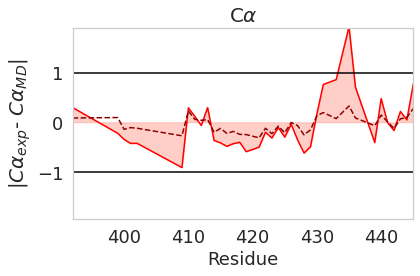

In [96]:
def plot_CA_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()
            if t == 'CA':
                plt.plot(np.asarray(resid), (initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), (reweight - exp), color='darkred',
                         label="RMSD_final:%6.3lf" % rmsd_f, linestyle='dashed')
                plt.fill_between(np.asarray(resid), (initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$C\alpha_{exp}$- $C\alpha_{MD}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.axhline(y=1, color='black', linestyle='-')
                plt.axhline(y=-1, color='black', linestyle='-')
                # plt.xticks(fontsize=16)
                # plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.yticks([-1, 0, 1])    
                plt.grid()
                plt.ylim(-1.95,1.9)
                plt.xlim(392, 445)
                plt.xlabel('Residue', size=18)
                # plt.legend(loc='upper left')
                plt.tight_layout()
                plt.savefig('%s/%s.weird.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

plot_CA_data(final_weights)

In [97]:
def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E, dsspH, dsspE


In [98]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")
    return (s[k]/2**(d-k))

def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf

[['C' 'H' 'H' ... 'H' 'C' 'C']
 ['C' 'H' 'H' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'E' 'C' 'C']
 ...
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'H' 'H' 'C']
 ['C' 'C' 'C' ... 'H' 'H' 'C']]


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


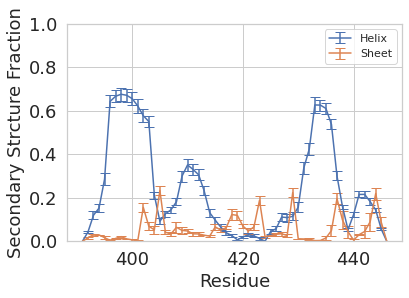

In [99]:
trjH1 = md.load(rep0, top=pdb, stride=1)[0:-1]
top = trjH1.topology
H1 = top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 390
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)

print(dsspH1)
H1_H, H1_E, dsspH, dsspE = dssp_convert(dsspH1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt('%s/dssp.H.dat' % outdir, dsspH)
np.savetxt('%s/dssp.E.dat' % outdir, dsspE)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


(59746, 56)


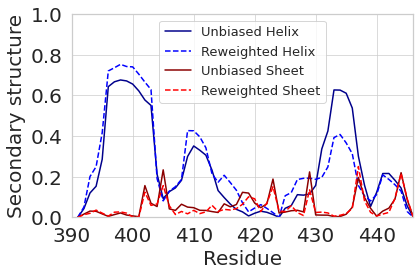

<Figure size 432x288 with 0 Axes>

In [100]:
helix_prop = dsspH
sheet_prop = dsspE
Hprop = np.sum(helix_prop, axis=0).astype(float)/len(helix_prop)
Eprop = np.sum(sheet_prop, axis=0).astype(float)/len(sheet_prop)

print(helix_prop.shape)
reweight_Hprop = []
reweight_Eprop = []
for i in range(0, len(Hprop)):
    reweight_Hprop.append(np.dot(helix_prop[:, i], final_weights))
    reweight_Eprop.append(np.dot(sheet_prop[:, i], final_weights))

plt.plot(hres_renum, Hprop, color='darkblue', label='Unbiased Helix')
plt.ylim(0, 1.0)
plt.xlim(390, 446)
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Reweighted Helix', linestyle='dashed')
plt.plot(hres_renum, Eprop, color='darkred', label='Unbiased Sheet')
plt.plot(hres_renum, reweight_Eprop, color='red',
         label='Reweighted Sheet', linestyle='dashed')
plt.xlabel('Residue', size=20)
plt.ylabel('Secondary structure', size=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.grid(True, linewidth=1, alpha=0.7)
plt.tight_layout()

plt.legend(loc='upper center', fontsize=13)

np.savetxt('%s/Hprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Hprop)))
np.savetxt('%s/Eprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Eprop)))

plt.savefig('%s/SS.reweight.pdf' % outdir)
plt.show()
plt.clf()


In [101]:
d2d_head = ['#num','res','Helix','Beta','coil','PPII','SS']
d2d1 = pd.read_csv(main_path + 'Reweight_Files/epi001.d2d.txt', delim_whitespace=True, names=d2d_head)
d2d1=d2d1.fillna(0)
d2d1 = d2d1.iloc[0:-1]
d2d1['#num'] = d2d1['#num'].astype('int64')
# # add 10 to each residue number
# d2d1['#num'] = int(d2d1['#num']) + 7
d2d1

,#num,res,Helix,Beta,coil,PPII,SS
0,391,L,0.000,0.000,0.000,0.000,0
1,392,D,0.000,0.009,0.924,0.067,C
2,393,Y,0.000,0.000,0.000,0.000,0
3,394,G,0.000,0.000,0.000,0.000,0
4,395,S,0.000,0.000,0.000,0.000,0
5,396,A,0.000,0.000,0.000,0.000,0
6,397,W,0.000,0.000,0.000,0.000,0
7,398,A,0.000,0.000,0.000,0.000,0
8,399,A,0.573,0.000,0.427,0.000,H
9,400,A,0.542,0.000,0.458,0.000,H


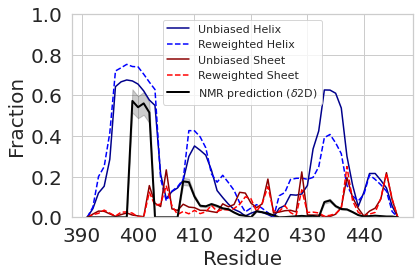

<Figure size 432x288 with 0 Axes>

In [102]:
plt.plot(hres_renum, Hprop, color='darkblue', label='Unbiased Helix')
plt.ylim(0, 1.0)
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Reweighted Helix', linestyle='dashed')
plt.plot(hres_renum, Eprop, color='darkred', label='Unbiased Sheet')
plt.plot(hres_renum, reweight_Eprop, color='red',
         label='Reweighted Sheet', linestyle='dashed')
plt.plot(d2d1['#num'], d2d1['Helix'], label=r'NMR prediction ($\delta$2D)', linewidth=2, color = 'black')
plt.fill_between(d2d1['#num'], d2d1['Helix']-0.1*d2d1['Helix'], d2d1['Helix']+0.1*d2d1['Helix'], alpha=0.2, color = 'black')
plt.xlabel('Residue', size=20)
plt.ylabel('Fraction', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.legend(loc='upper center', fontsize=11)

np.savetxt('%s/Hprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Hprop)))
np.savetxt('%s/Eprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Eprop)))

plt.savefig('%s/SS.reweight.png' % outdir)
plt.show()
plt.clf()

In [103]:
# Read reweighted file
reweight_APO_Hprop = np.loadtxt('%s/R2_R3_APO/Hprop.reweight.dat' % main_path)[:, 1]
APO_Hprop = np.loadtxt('%s/R2_R3_APO/Hprop.err.dat' % main_path)[:, 1:]
print(APO_Hprop)

[[0.         0.        ]
 [0.04375219 0.00802328]
 [0.13895695 0.01705122]
 [0.18515926 0.01799844]
 [0.29786489 0.03286742]
 [0.64753238 0.02272795]
 [0.68743437 0.0238745 ]
 [0.6979349  0.0242547 ]
 [0.69513476 0.01690707]
 [0.68813441 0.01446417]
 [0.65873294 0.01528459]
 [0.63458173 0.01820271]
 [0.52817641 0.01765668]
 [0.16625831 0.01808928]
 [0.09520476 0.01760333]
 [0.17815891 0.02321006]
 [0.18165908 0.0204496 ]
 [0.22506125 0.02445736]
 [0.29681484 0.02599782]
 [0.30696535 0.0268109 ]
 [0.29051453 0.02542215]
 [0.32026601 0.016446  ]
 [0.2499125  0.01795056]
 [0.16170809 0.01741375]
 [0.07560378 0.01038602]
 [0.04900245 0.00956812]
 [0.02835142 0.00878143]
 [0.02170109 0.00766204]
 [0.01925096 0.01093467]
 [0.06755338 0.01389646]
 [0.07525376 0.01370671]
 [0.06300315 0.01085259]
 [0.00840042 0.00209652]
 [0.         0.        ]
 [0.10885544 0.01113453]
 [0.1540077  0.01737949]
 [0.18900945 0.01815014]
 [0.19250963 0.01624178]
 [0.19145957 0.01748931]
 [0.20021001 0.01767281]


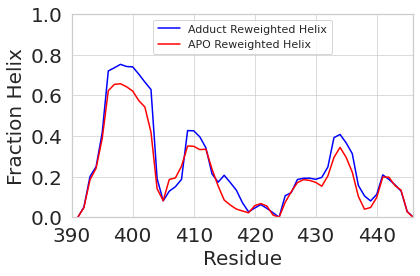

<Figure size 432x288 with 0 Axes>

In [104]:
#Plot Adduct helix and reweight
# plt.plot(hres_renum, Hprop, color='darkblue', label='Adduct Unbiased Helix')
plt.ylim(0, 1.0)
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Adduct Reweighted Helix')

# Plot APO and APO reweight
# plt.plot(hres_renum, APO_Hprop[:,0], color='darkred', label='APO Unbiased Helix')
plt.plot(hres_renum, reweight_APO_Hprop, color='red',
            label='APO Reweighted Helix')
plt.xlabel('Residue', size=20)
plt.ylabel('Fraction Helix', size=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.legend(loc='upper center', fontsize=11)
plt.xlim(390, 446)
plt.grid(True, linewidth=1, alpha=0.7)

np.savetxt('%s/Hprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Hprop)))
np.savetxt('%s/Eprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Eprop)))

plt.savefig('%s/SS.single.reweight.pdf' % outdir)
plt.show()
plt.clf()

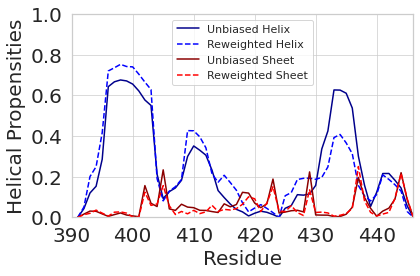

<Figure size 432x288 with 0 Axes>

In [105]:
#Plot Adduct helix and reweight
# plt.plot(hres_renum, Hprop, color='darkblue', label='Adduct Unbiased Helix')
plt.ylim(0, 1.0)
plt.xlim(390, 446)
# plt.plot(hres_renum, reweight_Hprop, color='blue',
#          label='Adduct Reweighted Helix')

# Plot APO and APO reweight
plt.plot(hres_renum, Hprop, color='darkblue', label='Unbiased Helix')
plt.plot(hres_renum, reweight_Hprop, color='blue',
         label='Reweighted Helix', linestyle='dashed')
plt.plot(hres_renum, Eprop, color='darkred', label='Unbiased Sheet')
plt.plot(hres_renum, reweight_Eprop, color='red',
         label='Reweighted Sheet', linestyle='dashed')
# plt.plot(hres_renum, reweight_APO_Hprop, color='black',
#             label='APO Reweighted Helix')
plt.xlabel('Residue', size=20)
plt.ylabel('Helical Propensities', size=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.legend(loc='upper center', fontsize=11)
plt.grid(True, linewidth=1, alpha=0.7)
np.savetxt('%s/Hprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Hprop)))
np.savetxt('%s/Eprop.reweight.dat' %
           outdir, np.column_stack((hres_renum, reweight_Eprop)))

plt.savefig('%s/SS.reweight.pdf' % outdir)
plt.show()
plt.clf()

In [106]:
contact_maps = []
contact_maps_reweight = []
for i in range(1, 57):
    contact_map = []
    contact_map_reweight = []
    for j in range(1, 57):
        if i == j:
            contacts = 0
            contacts_reweight = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
            contacts_reweight = np.dot(contact[0:-1,0],final_weights)
        contact_map.append(contacts)
        contact_map_reweight.append(contacts_reweight)
    contact_maps.append(contact_map)
    contact_maps_reweight.append(contact_map_reweight)
final_map = np.asarray(contact_maps).astype(float)
final_map_reweight = np.asarray(contact_maps_reweight).astype(float)


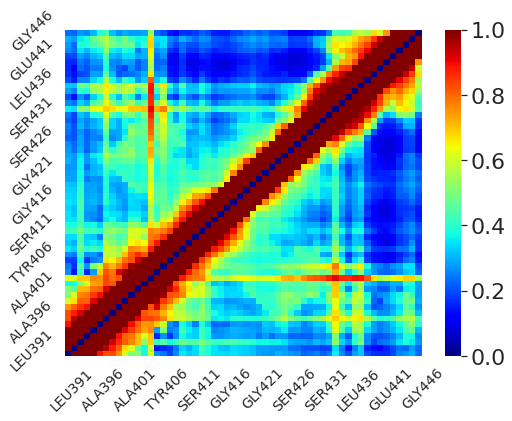

In [107]:
contact_map = final_map
sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(1, 57), sequence, rotation=45, size=14)
plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()
plt.savefig('%s/contact_map.pdf' % outdir, bbox_inches='tight')

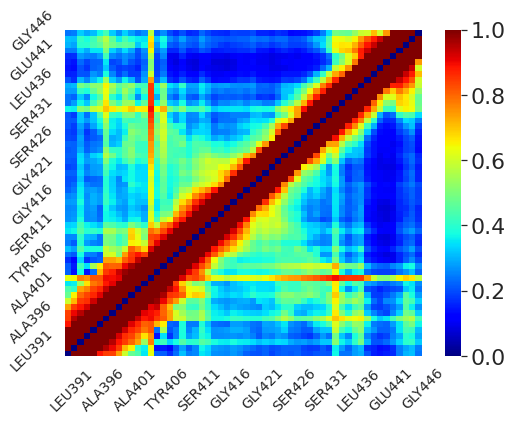

In [108]:
contact_map = final_map_reweight
sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(1, 57), sequence, rotation=45, size=14)
plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()
plt.savefig('%s/contact_map_reweight.pdf' % outdir, bbox_inches='tight')

In [109]:
helixBB = md.load_pdb(helixpdb)
trjBB = md.load(rep0, top=pdb, stride=1)
BB = trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")

trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
trjBB.center_coordinates()
helixBB.center_coordinates()

RMS_start = 1
RMS_stop = 51
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = helixBB.topology.select("residue %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trjBB, helixBB, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)

mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))


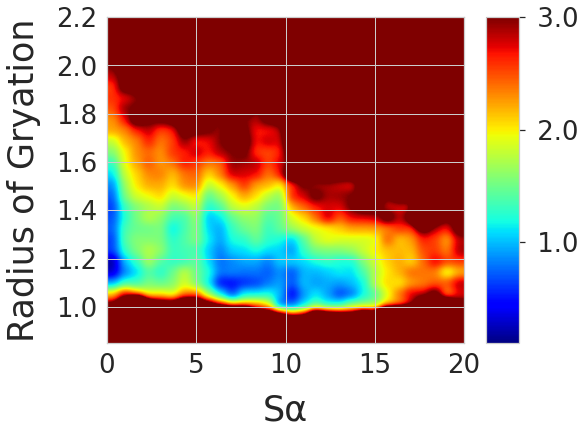

In [110]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.85, 2.2], [0, 20.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 19)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks([0, 5, 10, 15, 20], size=26)
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.savefig('%s/rg_Sa.pdf' % outdir, bbox_inches='tight')

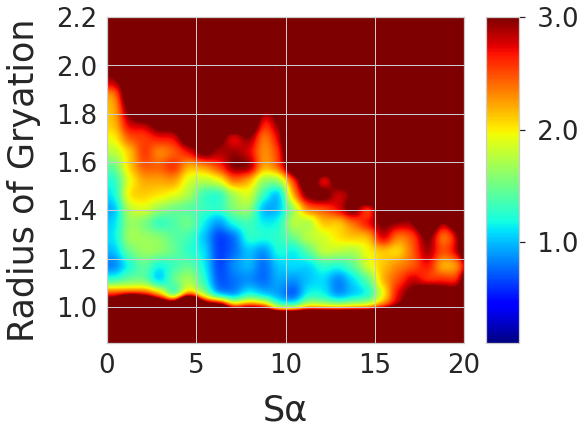

In [111]:
a, xedges, yedges = np.histogram2d(
    rg_CA[1:], Sa_total[1:], 30, [[0.85, 2.6], [0, 25.0]], normed=True, weights=final_weights)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 20)
plt.ylim(0.85, 2.2)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks([0, 5, 10, 15, 20], size=26)
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.savefig('%s/rg_Sa_reweight.pdf' % outdir, bbox_inches='tight')

Trajectory frames: 59747
Final weights frames: 59746
Mismatch detected: Trimming contact_matrix to match final_weights.
Direct reweighted contact probability:
 [0.10124141 0.17591139 0.14584274 0.34974848 0.20777675 0.2166483
 0.33578064 0.68719497 0.39357415 0.72669883 0.76357624 0.77120587
 1.         1.         1.         1.         1.         0.43759942
 0.27005517 0.37411844 0.19640633 0.22063213 0.32235531 0.20134615
 0.12703322 0.16103259 0.17702133 0.18413298 0.21351202 0.2107031
 0.28000481 0.28254136 0.284868   0.28613405 0.2352827  0.3035847
 0.26400493 0.24812038 0.39528033 0.41270684 0.40269441 0.34188009
 0.35200092 0.63410341 0.37928392 0.2534773  0.3668496  0.39936749
 0.17293364 0.13356075 0.08077381 0.08065282 0.12668636 0.16854079
 0.26937718 0.29727525 0.18368378 0.12921833]
Reweighted contact probability from blocking:
 [0.10124141 0.17591139 0.14584274 0.34974848 0.20777675 0.2166483
 0.33578064 0.68719497 0.39357415 0.72669883 0.76357624 0.77120587
 1.         1.

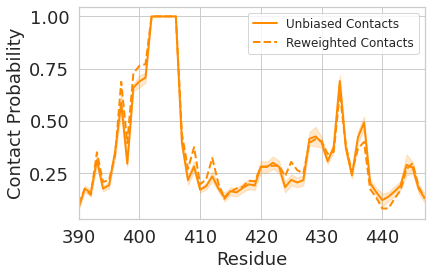

In [112]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyblock.blocking  # Ensure that pyblock is installed

main_path = '/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/'

outdir = os.path.join(main_path, 'reweight_trial/')
# --------------------------
# Provided function for Block Error Estimation
# --------------------------
def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave) / bound_frac
    be_bf = np.asarray(block_errors) / bound_frac
    return ave_bf, be_bf

# --------------------------
# 1. Setup and Compute Contacts
# --------------------------
# Parameters
residues = 58
residue_offset = 390
ligand_residue_index = 14  # Index of the ligand (adjust if needed)

# Create contact pairs: each protein residue (0-indexed) paired with the ligand.
contact_pairs = np.zeros((residues, 2), dtype=int)
for i in range(residues):
    contact_pairs[i] = [i, ligand_residue_index]

# Compute contacts using MDTraj with the 'closest-heavy' scheme
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
# The first element of the returned tuple is the distance array, with shape (n_frames, residues)
contacts = np.asarray(contact[0]).astype(float)

# Define a distance cutoff (in nm) for a contact to be considered "formed"
cutoff = 0.6
# Create the binary contact matrix (1 if contact exists, else 0)
contact_matrix = np.where(contacts < cutoff, 1, 0)

# --------------------------
# 2. Ensure Matching Number of Frames
# --------------------------
# Check if the number of frames in the trajectory (contact_matrix) matches final_weights
n_frames_trj = trj.n_frames
n_frames_weights = final_weights.shape[0]

print("Trajectory frames:", n_frames_trj)
print("Final weights frames:", n_frames_weights)

if n_frames_trj != n_frames_weights:
    print("Mismatch detected: Trimming contact_matrix to match final_weights.")
    contact_matrix = contact_matrix[:n_frames_weights, :]

# (Optional) Save the unweighted contact matrix
np.savetxt(outdir + 'contacts.traj.dat', contact_matrix, fmt='%i')

# --------------------------
# 3. Original (Unweighted) Contact Probability and Error Bars
# --------------------------
# The unweighted contact probability per residue is simply the average over frames.
ave_original, be_original = get_blockerrors_pyblock(contact_matrix, bound_frac=1.0)
# ave_original: contact probability per residue, be_original: corresponding error bars

# --------------------------
# 4. Reweighted Contact Probability and Error Bars
# --------------------------
# Compute the total weight
total_weight = np.sum(final_weights)
# Direct computation of reweighted contact probability:
#   P_rw = (sum_i w_i * contact_i) / (sum_i w_i)
reweighted_contact_prob_direct = np.dot(final_weights, contact_matrix) / total_weight

# To estimate errors using get_blockerrors_pyblock, we "embed" the weights.
# Create a new array where for each frame:
#    weighted_contacts[i, j] = (w_i / total_weight) * contact_matrix[i, j]
weighted_contacts = (final_weights / total_weight)[:, None] * contact_matrix

# Now, the average over frames of weighted_contacts is (P_rw / n_frames)
# Thus, we apply the block error routine and then multiply by n_frames.
ave_weighted, be_weighted = get_blockerrors_pyblock(weighted_contacts, bound_frac=1.0)
n_frames = final_weights.shape[0]  # now matching contact_matrix frames
reweighted_contact_prob = ave_weighted * n_frames
reweighted_contact_error = be_weighted * n_frames

# For reference, you can print both methods:
print("Direct reweighted contact probability:\n", reweighted_contact_prob_direct)
print("Reweighted contact probability from blocking:\n", reweighted_contact_prob)

# --------------------------
# 5. Save and Plot Both Contact Probabilities
# --------------------------
# Define residue numbers for plotting (offset by residue_offset)
resnum = np.linspace(residue_offset, residue_offset + residues - 1, residues)

# Save the data:
# Columns: [Residue, Original Contact Probability, Original Error, Reweighted Contact Probability, Reweighted Error]
all_data = np.column_stack((resnum, ave_original, be_original, reweighted_contact_prob, reweighted_contact_error))
np.savetxt(f'{outdir}/contact_probabilities.dat', all_data, fmt='%.4f', 
           header='Residue   OrigProb   OrigErr   RewProb   RewErr')

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyblock.blocking  # Ensure pyblock is installed

# --------------------------
# Provided function for Block Error Estimation
# --------------------------
def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)
    
    ave_bf = np.asarray(ave) / bound_frac
    be_bf = np.asarray(block_errors) / bound_frac
    return ave_bf, be_bf

# --------------------------
# 1. Setup and Compute Contacts
# --------------------------
# Parameters
residues = 58
residue_offset = 390
ligand_residue_index = 14  # Index of the ligand (adjust if needed)

# Create contact pairs: each protein residue (0-indexed) paired with the ligand.
contact_pairs = np.zeros((residues, 2), dtype=int)
for i in range(residues):
    contact_pairs[i] = [i, ligand_residue_index]

# Compute contacts using MDTraj with the 'closest-heavy' scheme
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
# The first element is the distance array (shape: [n_frames, residues])
contacts = np.asarray(contact[0]).astype(float)

# Define a distance cutoff (in nm) for a contact to be considered "formed"
cutoff = 0.6
# Create the binary contact matrix (1 if contact exists, else 0)
contact_matrix = np.where(contacts < cutoff, 1, 0)

# --------------------------
# 2. Ensure Matching Number of Frames
# --------------------------
n_frames_trj = trj.n_frames
n_frames_weights = final_weights.shape[0]

print("Trajectory frames:", n_frames_trj)
print("Final weights frames:", n_frames_weights)

if n_frames_trj != n_frames_weights:
    print("Mismatch detected: Trimming contact_matrix to match final_weights.")
    contact_matrix = contact_matrix[:n_frames_weights, :]

# (Optional) Save the unweighted contact matrix
np.savetxt(outdir + 'contacts.traj.dat', contact_matrix, fmt='%i')

# --------------------------
# 3. Original (Unweighted) Contact Probability and Error Bars
# --------------------------
# Compute unweighted contact probability per residue using your block error function.
ave_original, be_original = get_blockerrors_pyblock(contact_matrix, bound_frac=1.0)

# --------------------------
# 4. Reweighted Contact Probability and Error Bars
# --------------------------
# Compute the total weight
total_weight = np.sum(final_weights)
# Direct reweighted contact probability
reweighted_contact_prob_direct = np.dot(final_weights, contact_matrix) / total_weight

# To estimate errors via block averaging, we "embed" the weights.
weighted_contacts = (final_weights / total_weight)[:, None] * contact_matrix

# The simple average of weighted_contacts gives (P_rw / n_frames); we multiply by n_frames.
ave_weighted, be_weighted = get_blockerrors_pyblock(weighted_contacts, bound_frac=1.0)
n_frames = final_weights.shape[0]
reweighted_contact_prob = ave_weighted * n_frames
reweighted_contact_error = be_weighted * n_frames

# For reference, print the two methods:
print("Direct reweighted contact probability:\n", reweighted_contact_prob_direct)
print("Reweighted contact probability from blocking:\n", reweighted_contact_prob)

# --------------------------
# 5. Prepare Data for Plotting
# --------------------------
# Define residue numbers for plotting (residues are offset by residue_offset)
resnum = np.linspace(residue_offset, residue_offset + residues - 1, residues)

# Build arrays for plotting:
# For original contacts: columns are [Residue, Original Contact Probability, Original Error]
Contact = np.column_stack((resnum, ave_original, be_original))
# For reweighted contacts: columns are [Residue, Reweighted Contact Probability, Reweighted Error]
Contact_rew = np.column_stack((resnum, reweighted_contact_prob, reweighted_contact_error))

# (Optional) Save the data for future reference.
all_data = np.column_stack((resnum, ave_original, be_original, reweighted_contact_prob, reweighted_contact_error))
np.savetxt(f'{outdir}/contact_probabilities.dat', all_data, fmt='%.4f', 
           header='Residue   OrigProb   OrigErr   RewProb   RewErr')

# --------------------------
# 6. Plotting (Using the Provided Style)
# --------------------------
sns.set(style='whitegrid')
# plt.figure(figsize=(8, 6))
# E2_contact = np.loadtxt(outdir + 'E2_contact.be.pyblock.dat')
# Plot original (unweighted) contact probability with error band.
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Unbiased Contacts', linewidth=2)
plt.fill_between(Contact[:, 0],
                 Contact[:, 1] + Contact[:, 2],
                 Contact[:, 1] - Contact[:, 2],
                 color='darkorange', alpha=0.2)

# Plot reweighted contact probability with error band (dashed line).
sns.lineplot(x=Contact_rew[:, 0], y=Contact_rew[:, 1],
             color='darkorange', label='Reweighted Contacts', linestyle='dashed', linewidth=2)

# # Plot E2 contact probability with error band.
# sns.lineplot(x=E2_contact[:, 0], y=E2_contact[:, 1],
#              color='blue', label='EPI-002 Contacts', linewidth=2)
# plt.fill_between(E2_contact[:, 0],
#                  E2_contact[:, 1] + E2_contact[:, 2],
#                  E2_contact[:, 1] - E2_contact[:, 2],
#                  color='blue', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset + residues - 1)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig(outdir + 'ContactFraction.byResidue.ClosestHeavy.png')
plt.savefig(outdir + 'ContactFraction.byResidue.ClosestHeavy.pdf')